In [77]:
###################################################
# Make a graphical display of a foldamer
# Requires a pdb file produced by modelo2 by hansiu
###################################################
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import itertools

###################################################################################################
# Get the coordinates of the best configuration of an HP polymer as determined by modelo2,
# and assign colors to each H or P monomer
#
# Input:
# - pdbfile: a string naming a pdb file output as traj.pdb by a modelo2 simulated annealing process
#
# Outputs:
# - colors: a list of colors corresponding to the monomers in the polymer (red for H, blue for P)
# - coordinates: a list of lists of coordinate pairs [x, y]
###################################################################################################
def get_colors_and_coordinates(pdbfile):
    coordinates = []
    colors = [] # ala is hydrophobic so red; arg is polar (charged) so blue

    # read directly from output of modelo2 and extract the correct model on the fly
    with open(pdbfile) as f:
        for line in f:
            if line[:8] == 'MODEL 18':
                for line in f:
                    if line[:6] != 'ENDMDL': 
                        coordinates.append([int(line[35:38]),int(line[43:46])])
                        if line[17:20] == 'ALA':
                            colors.append('red')
                        else:
                            colors.append('blue')
    return colors, coordinates

###################################################################################################
# Display an HP polymer as connected beads on a lattice
#
# Input:
# - pdbfile: a string naming a pdb file output as traj.pdb by a modelo2 simulated annealing process
# - hpstring: a string representing the name of the file to which to save the graphic
#
# Output:
# - a graphic to be displayed on the screen and saved as hpstring.png
###################################################################################################
def display_hp_foldamer(pdbfile, hpstring):
    colors, coordinates = get_colors_and_coordinates(pdbfile)
    coords = np.array(coordinates)
    fig = plt.figure(1, figsize=(8,8))
    plt.grid(False)
    plt.axis('equal')
    plt.axis('off')
    plt.scatter(*coords.T, s=2500, c=colors, zorder=2, edgecolor='black', linewidth=2)
    plt.plot(*coords.T, color='black', linewidth=10, zorder=1)
    plt.savefig('%s.png' % hpstring, bbox_inches='tight')

In [81]:
##############################################################################################################################
# Test for catalytic "landing pad"
# 
# A landing pad has three or more H (red) residues on the outside of the foldamer
# That is to say, three or more H residues in a straight line (same X coordinate and consecutive Y coordinates or vice versa)
# and with no neighbors one side (the same side for all of them) and neighbors on the other side
# This function reads a set of amino acids and coordinates and returns the length of the longest landing pad
# It returns zero if there is no landing pad of three or more H residues
# 
# Strategy:
# 1. Find out which H residues have neighbors on one side (above, below, left, right) but not on the opposite side
# 2. Store that information in four arrays and sort those arrays to put consecutive points together
# 3. Determine the maximum number of vertically or horizontally consecutive points in any of those arrays
# 4. Return that maximum number -- if that maximum number is at least 3, we have a landing pad
# #############################################################################################################################


def neighbor_above_not_below (all_residues, point):
    if ([point[0], point[1] + 1] in all_residues) and ([point[0], point[1] - 1] not in all_residues):
        return True
    else:
        return False

def neighbor_below_not_above (all_residues, point):
    if [point[0], point[1] - 1] in all_residues and [point[0], point[1] + 1] not in all_residues:
        return True
    else:
        return False

def neighbor_left_not_right (all_residues, point):
    if [point[0] - 1, point[1]] in all_residues and [point[0] + 1, point[1]] not in all_residues:
        return True
    else:
        return False

def neighbor_right_not_left (all_residues, point):
    if [point[0] + 1, point[1]] in all_residues and [point[0] - 1, point[1]] not in all_residues:
        return True
    else:
        return False
    
def get_vertical_landing_pad_length (residues):
    if len(residues) < 3:
        return (0)
    max_landing_pad = 0
    unique_x = list({residues[i][0] for i in range(len(residues))})
    y_coordinates = []
    for x in unique_x:
        y_coordinates.append([residues[i][1] for i in range(len(residues)) if residues[i][0] == x])
    for i in range(len(y_coordinates)):
        data = y_coordinates[i]
        for k, g in itertools.groupby(enumerate(data), lambda x:x[1]-x[0]):
            consecutives = (list(map(itemgetter(1), g)))
            # print (consecutives)
            if len(consecutives) > max_landing_pad:
                max_landing_pad = len(consecutives)
    return max_landing_pad

def get_horizontal_landing_pad_length (residues):
    if len(residues) < 3:
        return (0)
    max_landing_pad = 0
    unique_y = list({residues[i][1] for i in range(len(residues))})
    x_coordinates = []
    for y in unique_y:
        x_coordinates.append([residues[i][0] for i in range(len(residues)) if residues[i][1] == y])
    for i in range(len(x_coordinates)):
        data = x_coordinates[i]
        for k, g in itertools.groupby(enumerate(data), lambda x:x[1]-x[0]):
            consecutives = (list(map(itemgetter(1), g)))
            # print (consecutives)
            if len(consecutives) > max_landing_pad:
                max_landing_pad = len(consecutives)
    return max_landing_pad

###################################################################################################
# Get the length of the best catalytic "landing pad" on the outside of an HP foldamer
#
# The foldamer is the best configuration of an HP polymer as determined by modelo2
#
# Input:
# - pdbfile: a string naming a pdb file output as traj.pdb by a modelo2 simulated annealing process
#
# Output:
# - an integer indicating the length of the best landing on the outside of the foldamer
###################################################################################################
def get_landing_pad_length(pdbfile):
    colors, coords = get_colors_and_coordinates(pdbfile)
    point_colors = colors
    all_residues = coords
    H_residues = [all_residues[i] for i in range(len(all_residues)) if point_colors[i] == 'red']
    has_nbrs_above_not_below = sorted([H_residues[i] for i in range(len(H_residues)) 
                              if neighbor_above_not_below(all_residues, H_residues[i])], key=lambda x: (x[1], x[0]))
    has_nbrs_below_not_above = sorted([H_residues[i] for i in range(len(H_residues)) 
                              if neighbor_below_not_above(all_residues, H_residues[i])], key=lambda x: (x[1], x[0]))
    has_nbrs_left_not_right = sorted([H_residues[i] for i in range(len(H_residues)) 
                             if neighbor_left_not_right(all_residues, H_residues[i])], key=lambda x: (x[0], x[1]))
    has_nbrs_right_not_left = sorted([H_residues[i] for i in range(len(H_residues)) 
                             if neighbor_right_not_left(all_residues, H_residues[i])], key=lambda x: (x[0], x[1]))

    return (max(get_horizontal_landing_pad_length (has_nbrs_above_not_below),
                get_horizontal_landing_pad_length (has_nbrs_below_not_above),
                get_vertical_landing_pad_length (has_nbrs_left_not_right),
                get_vertical_landing_pad_length (has_nbrs_right_not_left)))


landing pad length is...
2


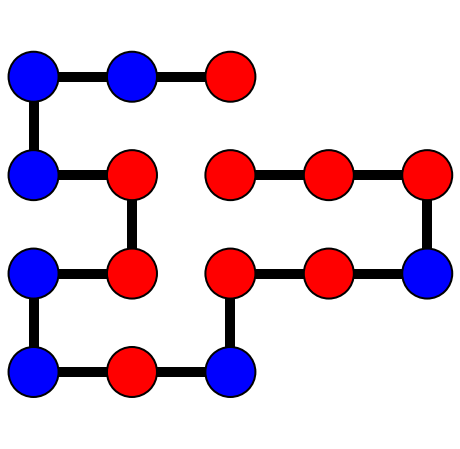

In [82]:
# Example for polymer HPPPHHPPHPHHPHHH
# modelo2 pdb file is provided

display_hp_foldamer('traj_HPPPHHPPHPHHPHHH.pdb', 'HPPPHHPPHPHHPHHH')

print ('landing pad length is...')
print(get_landing_pad_length('traj_HPPPHHPPHPHHPHHH.pdb'))

landing pad length is...
3


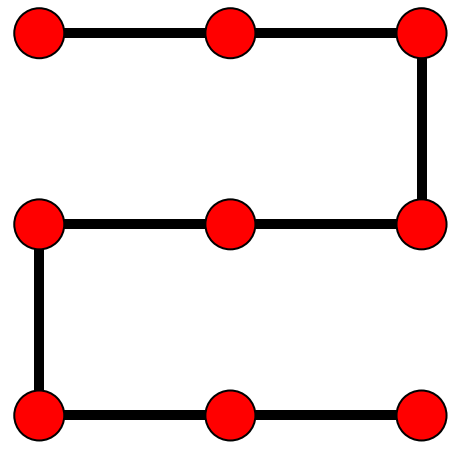

In [83]:
# Example for polymer HHHHHHHHH
# modelo2 pdb file is provided

display_hp_foldamer('traj_HHHHHHHHH.pdb', 'HHHHHHHHH')

print ('landing pad length is...')
print(get_landing_pad_length('traj_HHHHHHHHH.pdb'))